# Force analysis of ActuAtor

Summary of protocol for estimating forces on the membrane. Nuclei were traced from the EM images manually using Fiji. Assuming the Helfrich-Canham-Evans energy of the membrane,

$$E = \kappa_b \int_\Omega H^2dA + \int \lambda dA$$

where $\kappa_b$ is the bending modulus, $H$ is the mean curvature given by the two principal curvatures, $(k_1 + k_2)/2$, $\lambda$ the membrane tension, and $dA$ the area element. Given that the segmented EM images are plane curves, we assume naively that the out of plane principal curvature is naught ($k_2 = 0$). Rewriting as an energy density and simplifying,

$$E = \kappa_b \int_\Omega (k_1/2)^2 dA + \int \lambda dA = \frac{\kappa_bl}{4} \int_C k_1^2 ds + l\int \lambda ds$$

We introduce $l$, an arbitrary length scale relating the integrals over area, $\Omega$, and the plane curve, $C$; $ds$ is the arc-length element. To obtain the force density $f$, $f dA = f (lds) = -\nabla E$, we use automatic differentiation using `jax`. Note that the value of force density is independent of the choice of length scale $l$.

## Analysis

In [20]:
%matplotlib inline
from collections import defaultdict
from functools import partial
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

import automembrane.util as u
from automembrane.energy import (getEnergy2DClosed, getEnergy2DClosed_notrace)

u.matplotlibStyle(small=10, medium=12, large=14)

files = list(
    map(
        Path,
        [
            f"coordinates/{i}"
            for i in [
                "cell1/34D-grid2-s3-acta1_001_16.txt",
                "cell2/34D-grid3-ActA1_007_16.txt",
                "cell2/34D-grid3-ActA1_013_16.txt",
                "cell3/34D-grid2-s2_002_16.txt",
                "cell3/34D-grid2-s5_005_16.txt",
                "cell3/34D-grid3-ActA1_020_16.txt",
                "cell3/34D-grid3-s6_005_16.txt",
                "cell4/34D-grid2-s3_028_16.txt",
                "cell5/34D-grid3-ActA1_001_16.txt",
                "cell5/34D-grid3-ActA1_002_16.txt",
                "cell5/34D-grid3-ActA1_003_16.txt",
                "cell5/34D-grid3-ActA1_004_16.txt",
            ]
        ],
    )
)

images = {
    "34D-grid2-s3-acta1_001_16": 0.012723,
    "34D-grid3-ActA1_007_16": 0.015904,
    "34D-grid3-ActA1_013_16": 0.015904,
    "34D-grid2-s2_002_16": 0.015904,
    "34D-grid2-s5_005_16": 0.015904,
    "34D-grid3-ActA1_020_16": 0.015904,
    "34D-grid3-s6_005_16": 0.015904,
    "34D-grid2-s3_028_16": 0.015904,
    "34D-grid3-ActA1_001_16": 0.015904,
    "34D-grid3-ActA1_002_16": 0.015904,
    "34D-grid3-ActA1_003_16": 0.015904,
    "34D-grid3-ActA1_004_16": 0.015904,
}

Assuming bending modulus $1\times10^{-19}$ J and modest membrane tension $0.05$ mN/m.

In [21]:
parameters = {
    "Kb": 0.1 / 4,  # Bending modulus (pN um; original 1e-19 J)
    "Ksg": 50,  # Global stretching modulus (pN um/um^2; original 0.05 mN/m)
}
f_energy = partial(getEnergy2DClosed, **parameters)


We iterate over the segmentations. To ensure that the discrete curves are sufficiently sampled, we parameterize the curve using a B-spline and resample evenly. We perform `n_iter` steps of forward Euler energy relaxation to smooth out artifacts of the discretization. We choose the arbitrary length scale $L$ to be the dual length (i.e., the sum of half the length of each incident edge).

In [22]:
from scipy.interpolate import splprep, splev

n_vertices = 1000  # Number of vertices in resampling
dt = 5e-6  # Timestep
n_iter = 1000  # Number of relaxation steps
energy_log = np.zeros(n_iter)
data = defaultdict(dict)

for file in files:
    k = file.stem

    print("Processing:", k)
    original_coords = np.loadtxt(file)
    original_coords = np.vstack(
        (original_coords, original_coords[0])
    )  # Energy expects last point to equal first
    data[k]["original_coords"] = original_coords

    # Periodic cubic B-spline interpolation with no smoothing (s=0)
    tck, _ = splprep([original_coords[:, 0], original_coords[:, 1]], s=0, per=True)
    data[k]["spline"] = tck

    xi, yi = splev(np.linspace(0, 1, n_vertices), tck)
    coords = np.hstack((xi.reshape(-1, 1), yi.reshape(-1, 1)))

    # Perform energy relaxation
    relaxed_coords = coords
    for i in tqdm(range(0, n_iter), desc="Energy relaxation"):
        energy_log[i] = f_energy(relaxed_coords)
        relaxed_coords = np.array(
            relaxed_coords - u.egrad(f_energy)(relaxed_coords) * dt
        )
        relaxed_coords[-1] = relaxed_coords[0]
    data[k]["relaxed_coords"] = relaxed_coords
    # print(energy_log[::10])
    be, se = getEnergy2DClosed_notrace(relaxed_coords, **parameters)
    print(f"Bending Energy: {be:0.2f}; Stretching Energy: {se:0.2f}")

    # Compute dual length
    x = relaxed_coords[:-1, 0]
    y = relaxed_coords[:-1, 1]
    dx = np.roll(x, -1) - x
    dy = np.roll(y, -1) - y
    edgeLengths = np.sqrt(dx**2 + dy**2)
    dualLengths = ((edgeLengths + np.roll(edgeLengths, 1)) / 2.0).reshape(-1, 1)
    dualLengths = np.vstack((dualLengths, dualLengths[0]))
    data[k]["dualLengths"] = dualLengths

    forces = -u.egrad(f_energy)(relaxed_coords) / dualLengths
    data[k]["relaxed_forces"] = forces


Processing: 34D-grid2-s3-acta1_001_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 1.30; Stretching Energy: 2836.54
Processing: 34D-grid3-ActA1_007_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 0.83; Stretching Energy: 2157.02
Processing: 34D-grid3-ActA1_013_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 1.30; Stretching Energy: 2082.67
Processing: 34D-grid2-s2_002_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 3.07; Stretching Energy: 2490.68
Processing: 34D-grid2-s5_005_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 5.85; Stretching Energy: 2638.00
Processing: 34D-grid3-ActA1_020_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 2.39; Stretching Energy: 2550.04
Processing: 34D-grid3-s6_005_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 1.67; Stretching Energy: 2242.40
Processing: 34D-grid2-s3_028_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 1.38; Stretching Energy: 2057.83
Processing: 34D-grid3-ActA1_001_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 1.16; Stretching Energy: 2038.05
Processing: 34D-grid3-ActA1_002_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 0.88; Stretching Energy: 1880.63
Processing: 34D-grid3-ActA1_003_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 0.80; Stretching Energy: 2068.51
Processing: 34D-grid3-ActA1_004_16


Energy relaxation:   0%|          | 0/1000 [00:00<?, ?it/s]

Bending Energy: 0.97; Stretching Energy: 2049.96


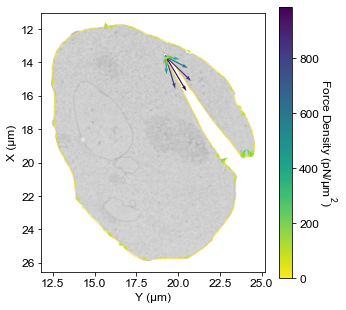

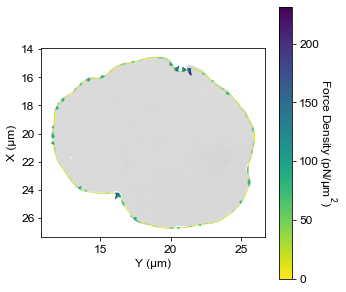

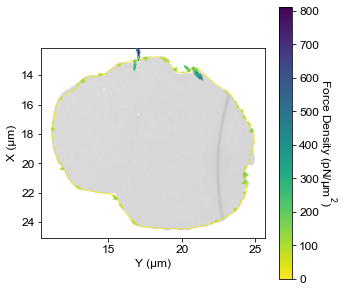

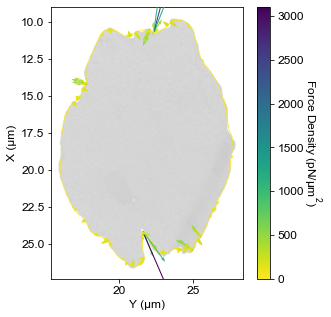

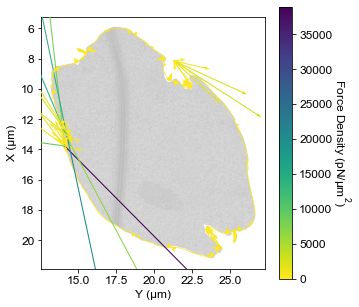

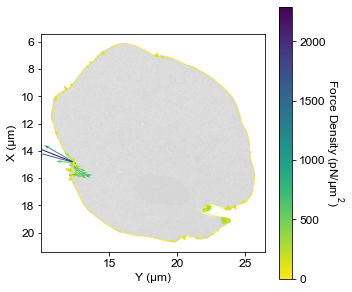

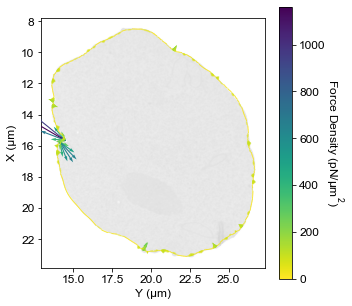

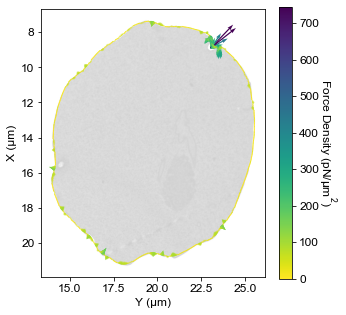

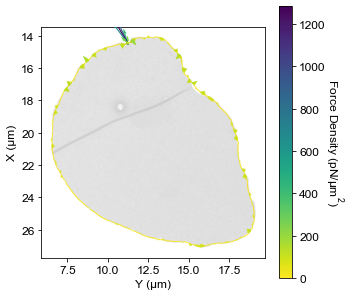

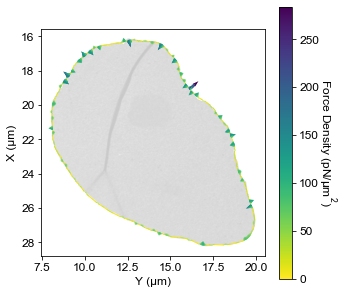

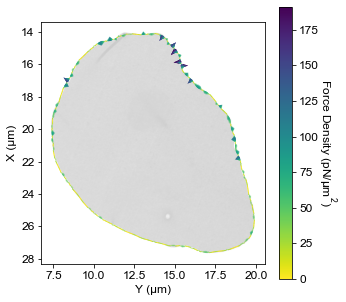

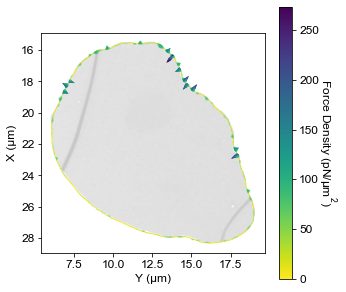

In [23]:
cm = mpl.cm.viridis_r

for file in files:
    k = file.stem
    d = data[k]

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]
    f_mag = np.linalg.norm(forces, axis=1)

    norm = mpl.colors.Normalize(vmin=np.amin(f_mag), vmax=np.amax(f_mag))
    # Map values to colors and add vertex color layer
    colors = cm(norm(f_mag))

    with Image.open(f"crop_images/{k}.png") as im:
        pixel_scale = images[k]

        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        # ax.plot(original_coords[:, 0], original_coords[:, 1], color="r")
        # ax.plot(relaxed_coords[:, 0], relaxed_coords[:, 1], color="gray", zorder=1)

        ax.quiver(
            relaxed_coords[:, 0],
            relaxed_coords[:, 1],
            forces[:, 0],
            -forces[:, 1],
            units="xy",
            label="force",
            color=colors,
            scale=400,
            width=0.07,
            zorder=10,
        )
        ax.set_ylabel(r"X (μm)")
        ax.set_xlabel(r"Y (μm)")

        x_lim = np.array(ax.get_xlim())
        y_lim = np.array(ax.get_ylim())

        x_lim_pix = (x_lim / pixel_scale).round()
        y_lim_pix = (y_lim / pixel_scale).round()

        ax.set_ylim(ax.get_ylim()[::-1])

        im = im.crop((x_lim_pix[0], y_lim_pix[0], x_lim_pix[1], y_lim_pix[1]))

        plt.imshow(
            im, alpha=0.3, extent=(x_lim[0], x_lim[1], y_lim[1], y_lim[0]), zorder=0
        )

        # Shrink current axis
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
        cbar.ax.get_yaxis().labelpad = 20
        cbar.ax.set_ylabel("Force Density ($\mathregular{pN/\mu m^2}$)", rotation=270)

        plt.savefig(f"Figures/{file.stem}_force.pdf")
        # plt.show()


In [24]:
for file in files:
    k = file.stem
    d = data[k]

    original_coords = d["original_coords"]
    relaxed_coords = d["relaxed_coords"]
    forces = d["relaxed_forces"]
    dualLengths = d["dualLengths"]

    print(
        "Mean dual length:",
        np.mean(dualLengths),
        "μm;",
        np.mean(dualLengths) ** 2,
        "μm^2",
    )


Mean dual length: 0.056785032 μm; 0.00322453987663196 μm^2
Mean dual length: 0.04318358 μm; 0.0018648215851515548 μm^2
Mean dual length: 0.041673888 μm; 0.0017367129011153365 μm^2
Mean dual length: 0.049848877 μm; 0.0024849105275453476 μm^2
Mean dual length: 0.052812606 μm; 0.0027891713626795323 μm^2
Mean dual length: 0.051051725 μm; 0.0026062785950610318 μm^2
Mean dual length: 0.04489381 μm; 0.002015454056260302 μm^2
Mean dual length: 0.04119739 μm; 0.0016972248904290055 μm^2
Mean dual length: 0.04079708 μm; 0.0016644018054441517 μm^2
Mean dual length: 0.03765255 μm; 0.0014177144012062076 μm^2
Mean dual length: 0.04141247 μm; 0.0017149925886448397 μm^2
Mean dual length: 0.041040085 μm; 0.001684288597827932 μm^2


Assuming an actin filament is ~7nm in diameter a conservative surface area occupancy is 49 $\mathrm{nm^2}$ or 4.9e-5 $\mathrm{\mu m^2}$. Depending on cell conditions a single actin filament can produce ~1 pN of force.

Then 1pN * A / 4.9e-5 μm^2 gives the maximum force assuming full surface coverage by pushing actin.


